In [1]:
import numpy as np
import os
import shutil
from pImpactR import MLI as mli
from pImpactR import opt
from pImpactR.util import Me
from copy import deepcopy as copy
import time
import pickle
import pandas as pd

# Read MLI input for settings

In [2]:
elems,lattices,labor = mli.readInputfile('mli.in.t3_iota_8_4_t0p4.optimized')

setarclen is not recognized. skipping...
autoconcat is not recognized. skipping...
autoapply is not recognized. skipping...
reftraj is not recognized. skipping...
fit is not recognized. skipping...
bip is not recognized. skipping...
tip is not recognized. skipping...


In [3]:
energy=elems[0].energy*1.0e9
gam0 = energy/Me
bet0 = np.sqrt(1.0-1.0/gam0**2)
bg0 =gam0*bet0
mass = Me

# prepare particles

In [4]:
NL_nu = 0.3
NL_L  = 1.8
NL_c  = 0.01
NL_t  = 0.4
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)
k = 2*alfx/betx


f3 = k/(2*bet0)
f4 = k/(2*bet0*gam0)**2
print(bet0,k,f3,f4)


npt = 64
nturn = 1024 
Espread = 1.0e-2

0.99999423665409 1.4544633270832747 0.727235854853427 4.191323867725334e-06


In [5]:
def MLI2norm(data_in,sign=1):
    data=data_in.copy()
#     data[:,5] = -bet0*data[:,5]*(1.0+0.5*data[:,5]/gam0**2-0.5*(bet0/gam0)**2*data[:,5]*data[:,5])
#     data[:,5] = -bet0*data[:,5]*(1.0+0.5*data[:,5]/gam0**2-0.5*(bet0/gam0)**2*data[:,5]*data[:,5])
    data[:,5] = np.sqrt(1.0-2.0*data[:,5]/bet0+data[:,5]**2)-1.0
    data[:,1] = (data[:,0]*alfx*sign/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx*sign/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    return data
    
def norm2MLI(data_in,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c
#     data[:,5] = -data[:,5]/bet0-0.5*(data[:,5]/(bet0*gam0))**2-0.5*(data[:,5]/(bet0*gam0))**3*gam0
    data[:,5] = -np.sqrt((1.0+data[:,5])**2+1.0/(bet0*gam0)**2)+1.0/bet0
    return data

In [6]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10,n=1):
    f = truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return f.rvs(n)

In [7]:
x=get_truncated_normal(sd=0.1,low=-0.3,upp=0.3,n=npt*5)
pData0=np.zeros([npt,6])
pData0[:,[0,1,2,3,5]]=x.reshape([npt,5])
pData0[:,5] = pData0[:,5]/0.1*Espread

pDataIn = norm2MLI(pData0,sign=1)
np.savetxt('rays.in',pDataIn)

# Cmds

In [8]:
storemap=mli.getElem.stm(nmap=1)
getmap  =mli.getElem.gtm(nmap=1,iopt=2)
writemap=mli.getElem.tmo(ifile=17)
raysin  =mli.getElem.raytrace(file1='rays.in',type='readonly')
dump    =mli.getElem.particledump(file='rays.out',precision=15)
track   =mli.getElem.autotrack(type='symplectic',order=5)
clear   =mli.getElem.clear
fin     =mli.getElem.fin

elemList = elems[:3].copy()
elemList = elemList + [storemap, getmap, writemap, raysin, dump, track, clear, fin]

# Lattice

In [9]:
nlinsert=mli.getElem.nlinsert()
readmap =mli.getElem.tmi(name='tmi',ifile=16)
M=np.zeros([6,6])
for i in range(6):
    M[i,i]=1
M[1,0] = -k
M[3,2] = -k
G=pd.DataFrame(index=[33,67,923],columns=['value'])
G['value']=[0.727241062159071,0.727241062159071,0.0]
readmap.map2file(M=M,G=G)

linedump=mli.getElem.line(name='linedump',elemList=[nlinsert,readmap,dump])

elemList = elemList + [nlinsert,readmap]

# Labor

In [10]:
labor = [raysin.name,track.name,str(nturn)+'*'+linedump.name,fin.name]

#  Run

In [11]:
def getTBT(npt,nturn,fname='rays.out'):
    TBT = np.loadtxt(fname)
    TBT = TBT[:npt*nturn,:6]
    out = np.zeros([npt,nturn,6])
    for i in range(nturn):
        out[:,i,:] = TBT[i*npt:(i+1)*npt,:]
        out[:,i,:] = MLI2norm(out[:,i,:])
    return out

In [12]:
mli.writeInputfile(elemList,[linedump],labor)

G=pd.DataFrame(index=[923],columns=['value'])
G['value']=[0.0]
readmap.map2file(M=M,G=G)
mli.run()
TBT0 = getTBT(npt,nturn)
print(TBT0.shape)

G=pd.DataFrame(index=[33,67,923],columns=['value'])
G['value']=[0.5*k/bet0,0.5*k/bet0,0.0]
readmap.map2file(M=M,G=G)
mli.run()
TBT1 = getTBT(npt,nturn)
print(TBT1.shape)

G=pd.DataFrame(index=[33,67,104,184,923],columns=['value'])
G['value']=[0.5*k/bet0,0.5*k/bet0,k/(2.0*bet0*gam0)**2,k/(2.0*bet0*gam0)**2,0.0]
readmap.map2file(M=M,G=G)
mli.run()
TBT2 = getTBT(npt,nturn)
print(TBT2.shape)

(64, 1024, 6)
(64, 1024, 6)
(64, 1024, 6)


# Check invariants

In [13]:
def getInv(xn,pxn,yn,pyn,delta,tau=NL_t):
    z = xn + 1j*yn
    U = np.real(z/np.sqrt(1-z**2)*np.arcsin(z))
    W = np.real(2*xn/np.sqrt(1-z**2)*np.arcsin(z))
    Hn = 0.5*(xn**2+pxn**2+yn**2+pyn**2)   +tau*U/(1.0+delta)
    In = (xn*pyn -yn*pxn)**2 +xn**2+pxn**2 +tau*W/(1.0+delta)
    return Hn,In

def getInvTBT(TBT):
    npt,nturn,dummy = TBT.shape
    InvTBT = np.zeros([npt,nturn,2])
    for iturn in range(nturn):
        data = TBT[:,iturn,:]
        for ipt in range(npt):
            xn    = data[ipt,0]
            pxn   = data[ipt,1]
            yn    = data[ipt,2]
            pyn   = data[ipt,3]
            delta = data[ipt,5]
            InvTBT[ipt,iturn,:] = getInv(xn,pxn,yn,pyn,delta)
    return InvTBT

In [14]:
Inv0 = getInvTBT(TBT0)
Inv1 = getInvTBT(TBT1)
Inv2 = getInvTBT(TBT2)

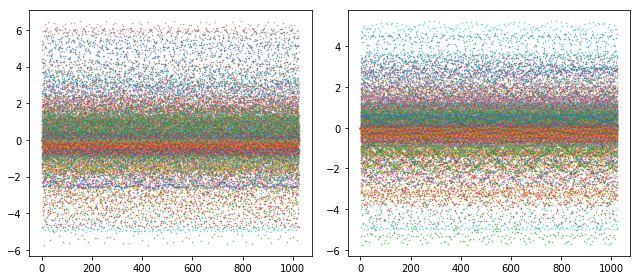

In [27]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot((Inv0[i,:,0]/Inv0[i,0,0]-1.0)*100,marker='.',ls='',alpha=0.7,markersize=1.0)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot((Inv0[i,:,1]/Inv0[i,0,1]-1.0)*100,marker='.',ls='',alpha=0.7,markersize=1.0)
plt.tight_layout()

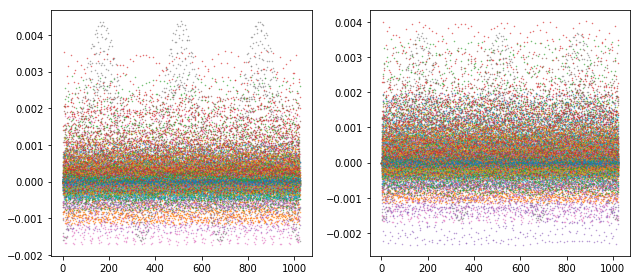

In [26]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot((Inv1[i,:,0]/Inv1[i,0,0]-1.0)*100,marker='.',ls='',alpha=0.7,markersize=1.0)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot((Inv1[i,:,1]/Inv1[i,0,1]-1.0)*100,marker='.',ls='',alpha=0.7,markersize=1.0)
plt.tight_layout()

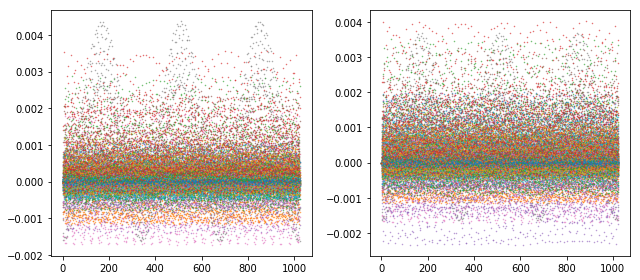

In [25]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot((Inv2[i,:,0]/Inv2[i,0,0]-1.0)*100,marker='.',ls='',alpha=0.7,markersize=1.0)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot((Inv2[i,:,1]/Inv2[i,0,1]-1.0)*100,marker='.',ls='',alpha=0.7,markersize=1.0)
plt.tight_layout()

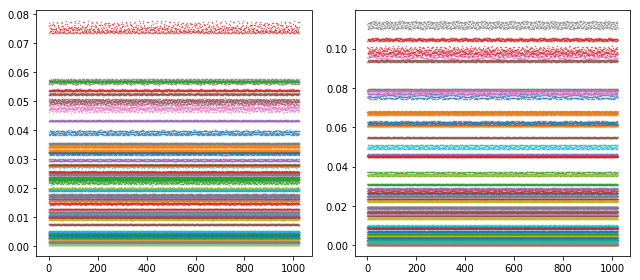

In [24]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv0[i,:,0],marker='.',ls='',alpha=0.7,markersize=1.0)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv0[i,:,1],marker='.',ls='',alpha=0.7,markersize=1.0)
plt.tight_layout()

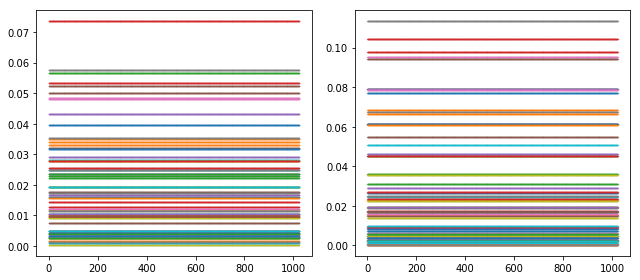

In [22]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv1[i,:,0],marker='.',ls='',alpha=0.7,markersize=1.0)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv1[i,:,1],marker='.',ls='',alpha=0.7,markersize=1.0)
plt.tight_layout()

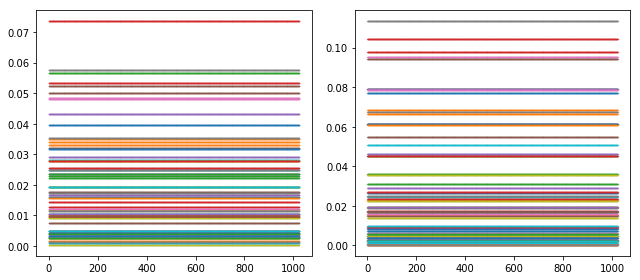

In [23]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv2[i,:,0],marker='.',ls='',alpha=0.7,markersize=1.0)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv2[i,:,1],marker='.',ls='',alpha=0.7,markersize=1.0)
plt.tight_layout()